##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Training and Evaluation with TensorFlow Keras



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/alpha/guide/keras/training_and_evaluation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/guide/keras/training_and_evaluation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/guide/keras/training_and_evaluation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>



This guide covers training, evaluation, and prediction (inference)  models in TensorFlow 2.0 in two broad situations:

- When using built-in APIs for training & validation (such as `model.fit()`, `model.evaluate()`, `model.predict()`). This is covered in the section **"Using build-in training & evaluation loops"**.
- When writing custom loops from scratch using eager execution and the `GradientTape` object. This is covered in the section **"Writing your own training & evaluation loops from scratch"**.

In general, whether you are using built-in loops or writing your own, model training & evaluation works strictly in the same way across every kind of Keras model -- Sequential models, models built with the Functional API, and models written from scratch via model subclassing.

This guide doesn't cover distributed training.

## Setup

In [0]:
!pip install pydot
!apt-get install graphviz

Reading package lists... Done
Building dependency tree
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

## Part I: Using build-in training & evaluation loops

When passing data to the built-in training loops of a model, you should either use **Numpy arrays** (if your data is small and fits in memory) or **tf.data Dataset** objects. In the next few paragraphs, we'll use the MNIST dataset as Numpy arrays, in order to demonstrate how to use optimizers, losses, and metrics.

### API overview: a first end-to-end example

Let's consider the following model (here, we build in with the Functional API, but it could be a Sequential model or a subclassed model as well):





In [0]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Here's what the typical end-to-end workflow looks like, consisting of training, validation on a holdout set generated from the original training data, and finally evaluation on the test data:


In [0]:
# Load a toy dataset for the sake of this example
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are Numpy arrays)
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Specify the training configuration (optimizer, loss, metrics)
model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.SparseCategoricalCrossentropy(),
              # List of metrics to monitor
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

# Train the model by slicing the data into "batches"
# of size "batch_size", and repeatedly iterating over
# the entire dataset for a given number of "epochs"
print('# Fit model on training data')
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=3,
                    # We pass some validation for
                    # monitoring validation loss and metrics
                    # at the end of each epoch
                    validation_data=(x_val, y_val))

# The returned "history" object holds a record
# of the loss values and metric values during training
print('\nhistory dict:', history.history)

# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)

11493376/11490434 [==============================] - 0s 0us/step
# Fit model on training data
Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 5s 110us/sample - loss: 0.3377 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.2020 - val_sparse_categorical_accuracy: 0.9402
Epoch 2/3
50000/50000 [==============================] - 5s 107us/sample - loss: 0.1576 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.1379 - val_sparse_categorical_accuracy: 0.9616
Epoch 3/3
50000/50000 [==============================] - 5s 106us/sample - loss: 0.1143 - sparse_categorical_accuracy: 0.9650 - val_loss: 0.1128 - val_sparse_categorical_accuracy: 0.9681

history dict: {'loss': [0.33772996835231783, 0.15758442388363184, 0.11431736122608185], 'sparse_categorical_accuracy': [0.90532, 0.95276, 0.96504], 'val_loss': [0.2019659897595644, 0.13788076196610927, 0.1128087827205658], 'val_sparse_categorical_accuracy': [0.9402, 0.9616, 0.9681]}

# Evaluat

### Specifying a loss, metrics, and an optimizer

To train a model with `fit`, you need to specify a loss function, an optimizer, and optionally, some metrics to monitor.

You pass these to the model as arguments to the `compile()` method:



In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

The `metrics` argument should be a list -- you model can have any number of metrics.

If your model has multiple outputs, you can specify  different losses and metrics for each output,
and you can modulate to contribution of each output to the total loss of the model. You will find more details about this in the section "**Passing data to multi-input, multi-output models**".

Note that in many cases, the loss and metrics are specified via string identifiers, as a shortcut:


In [0]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

For later reuse, let's put our model definition and compile step in functions; we will call them several times across different examples in this guide.

In [0]:
def get_uncompiled_model():
  inputs = keras.Input(shape=(784,), name='digits')
  x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

def get_compiled_model():
  model = get_uncompiled_model()
  model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
  return model

#### Many built-in optimizers, losses, and metrics are available

In general, you won't have to create from scratch your own losses, metrics, or optimizers, because what you need is likely already part of the Keras API:

Optimizers:
- `SGD()` (with or without momentum)
- `RMSprop()`
- `Adam()`
- etc.

Losses:
- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- etc.

Metrics:
- `AUC()`
- `Precision()`
- `Recall()`
- etc.

#### Writing custom losses and metrics

If you need a metric that isn't part of the API, you can easily create custom metrics by subclassing the `Metric` class. You will need to implement 4 methods:

- `__init__(self)`,  in which you will create state variables for your metric.
- `update_state(self, y_true, y_pred, sample_weight=None)`, which uses the targets `y_true` and the model predictions `y_pred` to update the state variables.
- `result(self)`, which uses the state variables to compute the final results.
- `reset_states(self)`, which reinitializes the state of the metric.

State update and results computation are kept separate (in `update_state()` and `result()`, respectively) because in some cases, results computation might be very expensive, and would only be done periodically.

Here's a simple example showing how to implement a `CatgoricalTruePositives` metric, that counts how many samples where correctly classified as belonging to a given class:

In [0]:
class CatgoricalTruePositives(keras.metrics.Metric):

    def __init__(self, name='binary_true_positives', **kwargs):
      super(CatgoricalTruePositives, self).__init__(name=name, **kwargs)
      self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
      y_pred = tf.argmax(y_pred)
      values = tf.equal(tf.cast(y_true, 'int32'), tf.cast(y_pred, 'int32'))
      values = tf.cast(values, 'float32')
      if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, 'float32')
        values = tf.multiply(values, sample_weight)
      return self.true_positives.assign_add(tf.reduce_sum(values))  # TODO: fix

    def result(self):
      return tf.identity(self.true_positives)  # TODO: fix

    def reset_states(self):
      # The state of the metric will be reset at the start of each epoch.
      self.true_positives.assign(0.)


model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[CatgoricalTruePositives()])
model.fit(x_train, y_train,
          batch_size=64,
          epochs=3)


Epoch 1/3
50000/50000 [==============================] - 4s 76us/sample - loss: 0.0917 - binary_true_positives: 7792.0000
Epoch 2/3
50000/50000 [==============================] - 3s 67us/sample - loss: 0.0756 - binary_true_positives: 8026.0000
Epoch 3/3
50000/50000 [==============================] - 4s 70us/sample - loss: 0.0647 - binary_true_positives: 8459.0000


#### Handling losses and metrics that don't fit the standard signature

The overwhelming majority of losses and metrics can be computed from `y_true` and `y_pred`, where `y_pred` is an output of your model. But not all of them. For instance, a regularization loss may only require the activation of a layer (there are no targets in this case), and this activation may not be a model output.

In such cases, you can call `self.add_loss(loss_value)` from inside the `call` method of a custom layer. Here's a simple example that adds activity regularization (note that activity regularization is built-in in all Keras layers -- this layer is just for the sake of providing a concrete example):


In [0]:
class ActivityRegularizationLayer(layers.Layer):

  def call(self, inputs):
    self.add_loss(tf.reduce_sum(inputs) * 0.1)
    return inputs  # Pass-through layer.

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy')

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1)

50000/50000 [==============================] - 4s 75us/sample - loss: 2.5322


You can do the same for logging metric values:

In [0]:
class MetricLoggingLayer(layers.Layer):

  def call(self, inputs):
    # The `aggregation` argument defines
    # how to aggregate the per-batch values
    # over each epoch:
    # in this case we simply average them.
    self.add_metric(keras.backend.std(inputs),
                    name='std_of_activation',
                    aggregation='mean')
    return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy')
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1)

50000/50000 [==============================] - 4s 76us/sample - loss: 0.3366 - std_of_activation: 0.9773


In the [Functional API](functional.ipynb), you can also call `model.add_loss(loss_tensor)`, or `model.add_metric(metric_tensor, name, aggregation)`.

Here's a simple example:

In [0]:
inputs = keras.Input(shape=(784,), name='digits')
x1 = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x2 = layers.Dense(64, activation='relu', name='dense_2')(x1)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1),
                 name='std_of_activation',
                 aggregation='mean')

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss='sparse_categorical_crossentropy')
model.fit(x_train, y_train,
          batch_size=64,
          epochs=1)

50000/50000 [==============================] - 4s 80us/sample - loss: 2.5158 - std_of_activation: 0.0020



#### Automatically setting apart a validation holdout set

In the first end-to-end example you saw, we used the `validation_data` argument to pass a tuple
of Numpy arrays `(x_val, y_val)` to the model for evaluating a validation loss and validation metrics at the end of each epoch.

Here's another option: the argument `validation_split` allows you to automatically reserve part of your training data for validation. The argument value represents the fraction of the data to be reserved for validation, so it should be set to a number higher than 0 and lower than 1. For instance, `validation_split=0.2` means "use 20% of the data for validation", and `validation_split=0.6` means "use 60% of the data for validation".

The way the validation is computed is by *taking the last x% samples of the arrays received by the `fit` call, before any shuffling*.

You can only use `validation_split` when training with Numpy data.

In [0]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=3)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
40000/40000 [==============================] - 3s 82us/sample - loss: 0.3735 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.2413 - val_sparse_categorical_accuracy: 0.9272
Epoch 2/3
40000/40000 [==============================] - 3s 82us/sample - loss: 0.1688 - sparse_categorical_accuracy: 0.9499 - val_loss: 0.1781 - val_sparse_categorical_accuracy: 0.9468
Epoch 3/3
40000/40000 [==============================] - 3s 79us/sample - loss: 0.1232 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.1518 - val_sparse_categorical_accuracy: 0.9539


### Training & evaluation from tf.data Datasets

In the past few paragraphs, you've seen how to handle losses, metrics, and optimizers, and you've seen how to use the `validation_data` and `validation_split` arguments in `fit`, when your data is passed as Numpy arrays.

Let's now take a look at the case where your data comes in the form of a tf.data Dataset.

The tf.data API is a set of utilities in TensorFlow 2.0 for loading and preprocessing data in a way that's fast and scalable.

For a complete guide about creating Datasets, see [the tf.data documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf).

You can pass a Dataset instance directly to the methods `fit()`, `evaluate()`, and `predict()`:

In [0]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print('\n# Evaluate')
model.evaluate(test_dataset)

Epoch 1/3
782/782 [==============================] - 5s 7ms/step - loss: 0.3250 - sparse_categorical_accuracy: 0.9074
Epoch 2/3
782/782 [==============================] - 4s 6ms/step - loss: 0.1484 - sparse_categorical_accuracy: 0.9559
Epoch 3/3
782/782 [==============================] - 4s 5ms/step - loss: 0.1074 - sparse_categorical_accuracy: 0.9685

# Evaluate
157/157 [==============================] - 1s 3ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9665


[0.11368312350931062, 0.9665]

Note that the Dataset is reset at the end of each epoch, so it can be reused of the next epoch.

If you want to run training only on a specific number of batches from this Dataset, you can pass the `steps_per_epoch` argument, which specifies how many training steps the model should run using this Dataset before moving on to the next epoch.

If you do this, the dataset is not reset at the end of each epoch, instead we just keep drawing the next batches. The dataset will eventually run out of data (unless it is an infinitely-looping dataset).

In [0]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 1s 11ms/step - loss: 0.7733 - sparse_categorical_accuracy: 0.8067
Epoch 2/3
100/100 [==============================] - 0s 5ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.8922
Epoch 3/3
100/100 [==============================] - 1s 5ms/step - loss: 0.3379 - sparse_categorical_accuracy: 0.9011


#### Using a validation dataset

You can pass a Dataset instance as the `validation_data` argument in `fit`:

In [0]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3
782/782 [==============================] - 7s 8ms/step - loss: 0.3440 - sparse_categorical_accuracy: 0.9020 - val_loss: 0.1838 - val_sparse_categorical_accuracy: 0.9490
Epoch 2/3
782/782 [==============================] - 7s 9ms/step - loss: 0.1649 - sparse_categorical_accuracy: 0.9515 - val_loss: 0.1391 - val_sparse_categorical_accuracy: 0.9603
Epoch 3/3
782/782 [==============================] - 8s 10ms/step - loss: 0.1216 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.1208 - val_sparse_categorical_accuracy: 0.9672


At the end of each epoch, the model will iterate over the validation Dataset and compute the validation loss and validation metrics.

If you want to run validation only on a specific number of batches from this Dataset, you can pass the `validation_steps` argument, which specifies how many validation steps the model should run with the validation Dataset before interrupting validation and moving on to the next epoch:

In [0]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3,
          # Only run validation using the first 10 batches of the dataset
          # using the `validation_steps` argument
          validation_data=val_dataset, validation_steps=10)

Epoch 1/3
782/782 [==============================] - 9s 12ms/step - loss: 0.3359 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.3095 - val_sparse_categorical_accuracy: 0.9187
Epoch 2/3
782/782 [==============================] - 7s 9ms/step - loss: 0.1593 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.2196 - val_sparse_categorical_accuracy: 0.9438
Epoch 3/3
782/782 [==============================] - 7s 9ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.1840 - val_sparse_categorical_accuracy: 0.9469


Note that the validation Dataset will be reset after each use (so that you will always be evaluating on the same samples from epoch to epoch).

The argument `validation_split` (generating a holdout set from the training data) is not supported when training from Dataset objects, since this features requires the ability to index the samples of the datasets, which is not possible in general with the Dataset API.


### Other input formats supported

Besides Numpy arrays and TensorFlow Datasets, it's possible to train a Keras model using Pandas dataframes, or from Python generators that yield batches.

In general, we recommend that you use Numpy input data if your data is small and fits in memory, and Datasets otherwise.

### Using sample weighting and class weighting

Besides input data and target data, it is possible to pass sample weights or class weights to a model when using `fit`:

- When training from Numpy data: via the `sample_weight` and `class_weight` arguments.
- When training from Datasets: by having the Dataset return a tuple `(input_batch, target_batch, sample_weight_batch)` .

A "sample weights" array is an array of numbers that specify how much weight each sample in a batch should have in computing the total loss. It is commonly used in imbalanced classification problems (the idea being to give more weight to rarely-seen classes). When the weights used are ones and zeros, the array can be used as a *mask* for the loss function (entirely discarding the contribution of certain samples to the total loss).

A "class weights" dict is a more specific instance of the same concept: it maps class indices to the sample weight that should be used for samples belonging to this class. For instance, if class "0" is twice less represented than class "1" in your data, you could use `class_weight={0: 1., 1: 0.5}`.

Here's a Numpy example where we use class weights or sample weights to give more importance to the correct classification of class #5 (which is the digit "5" in the MNIST dataset).

In [0]:
import numpy as np

class_weight = {0: 1., 1: 1., 2: 1., 3: 1., 4: 1.,
                # Set weight "2" for class "5",
                # making this class 2x more important
                5: 2.,
                6: 1., 7: 1., 8: 1., 9: 1.}
model.fit(x_train, y_train,
          class_weight=class_weight,
          batch_size=64,
          epochs=4)

# Here's the same example using `sample_weight` instead:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.

model = get_compiled_model()
model.fit(x_train, y_train,
          sample_weight=sample_weight,
          batch_size=64,
          epochs=4)

Epoch 1/4
50000/50000 [==============================] - 4s 89us/sample - loss: 0.1040 - sparse_categorical_accuracy: 0.9715
Epoch 2/4
50000/50000 [==============================] - 4s 83us/sample - loss: 0.0872 - sparse_categorical_accuracy: 0.9751
Epoch 3/4
50000/50000 [==============================] - 4s 85us/sample - loss: 0.0734 - sparse_categorical_accuracy: 0.9789
Epoch 4/4
50000/50000 [==============================] - 4s 81us/sample - loss: 0.0657 - sparse_categorical_accuracy: 0.9818
Epoch 1/4
50000/50000 [==============================] - 4s 87us/sample - loss: 0.3647 - sparse_categorical_accuracy: 0.9063
Epoch 2/4
50000/50000 [==============================] - 5s 91us/sample - loss: 0.1703 - sparse_categorical_accuracy: 0.9525
Epoch 3/4
50000/50000 [==============================] - 4s 81us/sample - loss: 0.1276 - sparse_categorical_accuracy: 0.9647
Epoch 4/4
50000/50000 [==============================] - 4s 83us/sample - loss: 0.1016 - sparse_categorical_accuracy: 0.9719


Here's a matching Dataset example:

In [0]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=3)

Epoch 1/3
782/782 [==============================] - 9s 11ms/step - loss: 0.3666 - sparse_categorical_accuracy: 0.9046
Epoch 2/3
782/782 [==============================] - 7s 9ms/step - loss: 0.1646 - sparse_categorical_accuracy: 0.9539
Epoch 3/3
782/782 [==============================] - 7s 9ms/step - loss: 0.1178 - sparse_categorical_accuracy: 0.9677


### Passing data to multi-input, multi-output models

In the previous examples, we were considering a model with a single input (a tensor of shape `(764,)`) and a single output (a prediction tensor of shape `(10,)`). But what about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape `(32, 32, 3)` (that's `(height, width, channels)`) and a timeseries input of shape `(None, 10)` (that's `(timesteps, features)`). Our model will have two outputs computed from the combination of these inputs: a "score" (of shape `(1,)`) and a probability distribution over 5 classes (of shape `(10,)`).


In [0]:
from tensorflow import keras
from tensorflow.keras import layers

image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

Let's plot this model, so you can clearly see what we're doing here (note that the shapes shown in the plot are batch shapes, rather than per-sample shapes).

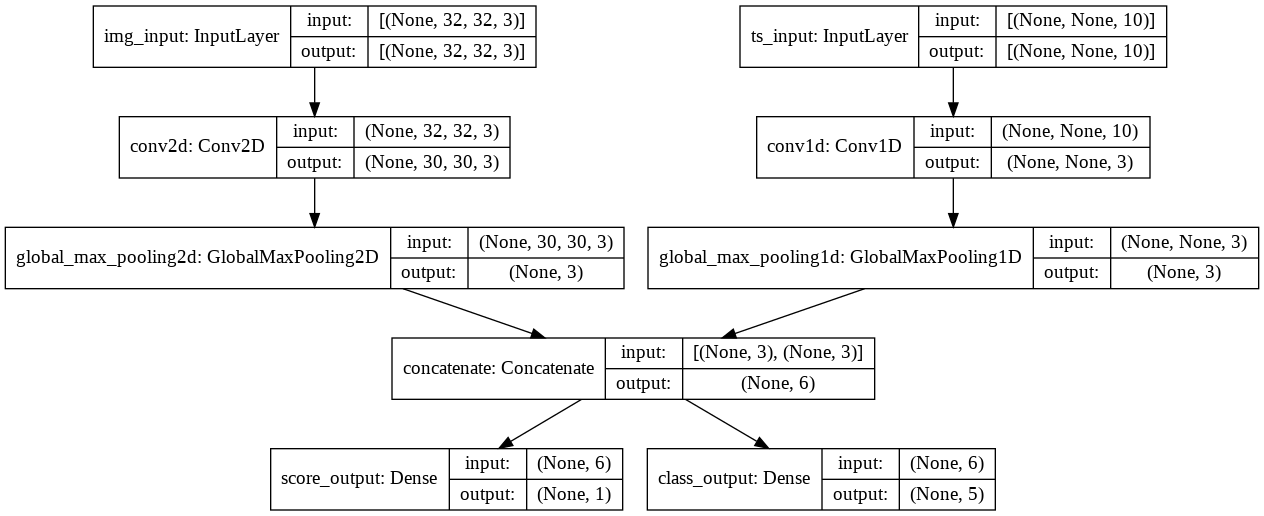

In [0]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

At compilation time, we can specify different losses to different ouptuts, by passing the loss functions as a list:

In [0]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

If we only passed a single loss function to the model, the same loss function would be applied to every output, which is not appropriate here.

Likewise for metrics:

In [0]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()],
    metrics=[[keras.metrics.MeanAbsolutePercentageError(),
              keras.metrics.MeanAbsoluteError()],
             [keras.metrics.CategoricalAccuracy()]])

Since we gave names to our output layers, we coud also specify per-output losses and metrics via a dict:

In [0]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]})

We recommend the use of explicit names and dicts if you have more than 2 outputs.

It's possible to give different weights to different output-specific losses (for instance, one might wish to privilege the "score" loss in our example, by giving to 2x the importance of the class loss), using the `loss_weight` argument:

In [0]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]},
    loss_weight={'score_output': 2., 'class_output': 1.})

You could also chose not to compute a loss for certain outputs, if these outputs meant for prediction but not for training:

In [0]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()])

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output': keras.losses.CategoricalCrossentropy()})

W0305 23:50:32.918388 140053718652800 training_utils.py:1152] Output score_output missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to score_output.


Passing data to a multi-input or multi-output model in `fit` works in a similar way as specifying a loss function in `compile`:
you can pass *lists of Numpy arrays (with 1:1 mapping to the outputs that received a loss function)* or *dicts mapping output names to Numpy arrays of training data*.

In [0]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# Generate dummy Numpy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets],
          batch_size=32,
          epochs=3)

# Alernatively, fit on dicts
model.fit({'img_input': img_data, 'ts_input': ts_data},
          {'score_output': score_targets, 'class_output': class_targets},
          batch_size=32,
          epochs=3)

Epoch 1/3
100/100 [==============================] - 1s 6ms/sample - loss: 7.6847 - score_output_loss: 0.7406 - class_output_loss: 6.9441
Epoch 2/3
100/100 [==============================] - 0s 1ms/sample - loss: 7.0638 - score_output_loss: 0.3140 - class_output_loss: 6.7499
Epoch 3/3
100/100 [==============================] - 0s 1ms/sample - loss: 6.7368 - score_output_loss: 0.1928 - class_output_loss: 6.5440
Epoch 1/3
100/100 [==============================] - 0s 4ms/sample - loss: 6.4485 - score_output_loss: 0.1420 - class_output_loss: 6.3065
Epoch 2/3
100/100 [==============================] - 0s 4ms/sample - loss: 6.1095 - score_output_loss: 0.1428 - class_output_loss: 5.9667
Epoch 3/3
100/100 [==============================] - 0s 4ms/sample - loss: 5.8362 - score_output_loss: 0.1219 - class_output_loss: 5.7143


Here's the Dataset use case: similarly as what we did for Numpy arrays, the Dataset should return
a tuple of dicts.

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ({'img_input': img_data, 'ts_input': ts_data},
     {'score_output': score_targets, 'class_output': class_targets}))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=3)

Epoch 1/3
2/2 [==============================] - 0s 152ms/step - loss: 5.6598 - score_output_loss: 0.1304 - class_output_loss: 5.5127
Epoch 2/3
2/2 [==============================] - 0s 107ms/step - loss: 5.5597 - score_output_loss: 0.1229 - class_output_loss: 5.4204
Epoch 3/3
2/2 [==============================] - 0s 145ms/step - loss: 5.4660 - score_output_loss: 0.1176 - class_output_loss: 5.3324


### Using callbacks

Callbacks in Keras are objects that are called at different point during training (at the start of an epoch, at the end of a batch, at the end of an epoch, etc.) and which can be used to implement behaviors such as:

- Doing validation at different points during training (beyond the built-in per-epoch validation)
- Checkpointing the model at regular intervals or when it exceeds a certain accuracy threshold
- Changing the learning rate of the model when training seems to be plateauing
- Doing fine-tuning of the top layers when training seems to be plateauing
- Sending email or instant message notifications when training ends or where a certain performance threshold is exceeded
- Etc.

Callbacks can be passed as a list to your call to `fit`:

In [0]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 4s 102us/sample - loss: 0.3712 - sparse_categorical_accuracy: 0.8955 - val_loss: 0.2237 - val_sparse_categorical_accuracy: 0.9325
Epoch 2/20
40000/40000 [==============================] - 4s 93us/sample - loss: 0.1754 - sparse_categorical_accuracy: 0.9483 - val_loss: 0.1784 - val_sparse_categorical_accuracy: 0.9440
Epoch 3/20
40000/40000 [==============================] - 3s 84us/sample - loss: 0.1255 - sparse_categorical_accuracy: 0.9619 - val_loss: 0.1583 - val_sparse_categorical_accuracy: 0.9514
Epoch 4/20
40000/40000 [==============================] - 4s 90us/sample - loss: 0.1003 - sparse_categorical_accuracy: 0.9703 - val_loss: 0.1404 - val_sparse_categorical_accuracy: 0.9587
Epoch 5/20
40000/40000 [==============================] - 4s 88us/sample - loss: 0.0829 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.1332 - val_sparse_categorical_accuracy: 0.9617
Epoch 6/20
400

#### Many built-in callbacks are available

- `ModelCheckpoint`: Periodically save the model.
- `EarlyStopping`: Stop training when training is no longer improving the validation metrics.
- `TensorBoard`: periodically write model logs that can be visualized in TensorBoard (more details in the section "Visualization").
- `CSVLogger`: streams loss and metrics data to a CSV file.
- etc.



#### Writing your own callback

You can create a custom callback by extending the base class keras.callbacks.Callback. A callback has access to its associated model through the class property `self.model`.

Here's a simple example saving a list of per-batch loss values during training:

```python
class LossHistory(keras.callbacks.Callback):

    def on_train_begin(self, logs):
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))
```

### Checkpointing models

When you're training model on relatively large datasets, it's crucial to save checkpoints of your model at frequent intervals.

The easiest way to achieve this is with the `ModelCheckpoint` callback:

In [0]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='mymodel_{epoch}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/3
39936/40000 [============================>.] - ETA: 0s - loss: 0.3635 - sparse_categorical_accuracy: 0.8971
Epoch 00001: val_loss improved from inf to 0.21655, saving model to mymodel_1.h5
40000/40000 [==============================] - 4s 108us/sample - loss: 0.3631 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.2166 - val_sparse_categorical_accuracy: 0.9347
Epoch 2/3
39360/40000 [============================>.] - ETA: 0s - loss: 0.1669 - sparse_categorical_accuracy: 0.9506
Epoch 00002: val_loss improved from 0.21655 to 0.17676, saving model to mymodel_2.h5
40000/40000 [==============================] - 4s 97us/sample - loss: 0.1669 - sparse_categorical_accuracy: 0.9505 - val_loss: 0.1768 - val_sparse_categorical_accuracy: 0.9456
Epoch 3/3
39424/40000 [============================>.] - ETA: 0s - loss: 0.1232 - sparse_categorical_accuracy: 0.9624
Epoch 00003: val_loss improved from 0.17676 to 0.15663, saving model to mymod

You call also write your own callback for saving and restoring models.

For a complete guide on serialization and saving, see [Guide to Saving and Serializing Models](./saving_and_serializing.ipynb).

### Using learning rate schedules

A common pattern when training deep learning models is to gradually reduce the learning as training progresses. This is generally known as "learning rate decay".

The learning decay schedule could be static (fixed in advance, as a function of the current epoch or the current batch index), or dynamic (responding to the current behavior of the model, in particular the validation loss).

#### Passing a schedule to an optimizer

You can easily use a static learning rate decay schedule by passing a schedule object as the `learning_rate` argument in your optimizer:


In [0]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

Several built-in schedules are available: `ExponentialDecay`, `PiecewiseConstantDecay`, `PolynomialDecay`, and `InverseTimeDecay`.

#### Using callbacks to implement a dynamic learning rate schedule

A dynamic learning rate schedule (for instance, decreasing the learning rate when the validation loss is no longer improving) cannot be achieved with these schedule objects since the optimizer does not have access to validation metrics.

However, callbacks do have access to all metrics, including validation metrics! You can thus achieve this pattern by using a callback that modifies the current learning rate on the optimizer. In fact, this is even built-in as the `ReduceLROnPlateau` callback.

### Visualizing loss and metrics during training

The best way to keep an eye on your model during training is to use [TensorBoard](https://www.tensorflow.org/tensorboard), a browser-based application that you can run locally that provides you with:

- Live plots of the loss and metrics for training and evaluation
- (optionally) Visualizations of the histograms of your layer activations
- (optionally) 3D visualizations of the embedding spaces learned by your `Embedding` layers

If you have installed TensorFlow with pip, you should be able to launch TensorBoard from the command line:

```
tensorboard --logdir=/full_path_to_your_logs
```

#### Using the TensorBoard callback

The easiest way to use TensorBoard with a Keras model and the `fit` method is the `TensorBoard` callback.

In the simplest case, just specify where you want te callback to write logs, and you're good to go:

```python
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir='/full_path_to_your_logs')
model.fit(dataset, epochs=10, callbacks=[tensorboard_cbk])
```

The `TensorBoard` callback has many useful options, including whether to log embeddings, histograms, and how often to write logs:

```python
keras.callbacks.TensorBoard(
  log_dir='/full_path_to_your_logs',
  histogram_freq=0,  # How often to log histogram visualizations
  embeddings_freq=0,  # How often to log embedding visualizations
  update_freq='epoch')  # How often to write logs (default: once per epoch)
```



## Part II: Writing your own training & evaluation loops from scratch

If you want lower-level over your training & evaluation loops than what `fit()` and `evaluate()` provide, you should write your own. It's actually pretty simple! But you should be ready to have a lot more debugging to do on your own.

### Using the GradientTape: a first end-to-end example

Calling a model inside a `GradientTape` scope enables you to retrieve the gradients of the trainable weights of the layer with respect to a loss value. Using an optimizer instance, you can use these gradients to update these variables (which you can retrieve using `model.trainable_variables`).

Let's reuse our initial MNIST model from Part I, and let's train it using mini-batch gradient with a custom training loop.

In [0]:
# Get the model.
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape() as tape:

      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      logits = model(x_batch_train)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss_value = loss_fn(y_batch_train, logits)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss_value, model.trainable_variables)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Training loss (for one batch) at step 0: 2.295337200164795
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.267664909362793
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.1268270015716553
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.0609934329986572
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 1.9627395868301392
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9132888317108154
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.7715450525283813
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.680647611618042
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 1.554194450378418
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5058209896087646
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.3611259460449219
Seen so far: 256

### Low-level handling of metrics

Let's add metrics to the mix. You can readily reuse the built-in metrics (or custom ones you wrote) in such training loops written from scratch. Here's the flow:

- Instantiate the metric at the start of the loop
- Call `metric.update_state()` after each batch
- Call `metric.result()` when you need to display the current value of the metric
- Call `metric.reset_states()` when you need to clear the state of the metric (typically at the end of an epoch)

Let's use this knowledge to compute `SparseCategoricalAccuracy` on validation data at the end of each epoch:

In [0]:
# Get model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)


# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update training metric.
    train_acc_metric(y_batch_train, logits)

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

  # Display metrics at the end of each epoch.
  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))
  # Reset training metrics at the end of each epoch
  train_acc_metric.reset_states()

  # Run a validation loop at the end of each epoch.
  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    # Update val metrics
    val_acc_metric(y_batch_val, val_logits)
  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training loss (for one batch) at step 0: 2.3286547660827637
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.297130823135376
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.168592929840088
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.037825107574463
Seen so far: 38464 samples
Training acc over epoch: 0.2502399981021881
Validation acc: 0.4449000060558319
Start of epoch 1
Training loss (for one batch) at step 0: 1.9728939533233643
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.9893989562988281
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.7468760013580322
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.6020689010620117
Seen so far: 38464 samples
Training acc over epoch: 0.5704200267791748
Validation acc: 0.6780999898910522
Start of epoch 2
Training loss (for one batch) at step 0: 1.476192831993103
Seen so far: 64 samples
Training 

### Low-level handling of extra losses

You saw in the previous section that it is possible for regularization losses to be added by a layer by calling `self.add_loss(value)` in the `call` method.

In the general case, you will want to take these losses into account in your custom training loops (unless you've written the model yourself and you already know that it creates no such losses).

Recall this example from the previous section, featuring a layer that creates a regularization loss:


In [0]:
class ActivityRegularizationLayer(layers.Layer):

  def call(self, inputs):
    self.add_loss(1e-2 * tf.reduce_sum(inputs))
    return inputs

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)


When you call a model, like this:

```python
logits = model(x_train)
```

the losses it creates during the forward pass are added to the `model.losses` attribute:

In [0]:
logits = model(x_train[:64])
print(model.losses)

[<tf.Tensor: id=999790, shape=(), dtype=float32, numpy=6.8533154>]


The tracked losses are first cleared at the start of the model `__call__`, so you will only see the losses created during this one forward pass. For instance, calling the model repeatedly and then querying `losses` only displays the latest losses, created during the last call:

In [0]:
logits = model(x_train[:64])
logits = model(x_train[64: 128])
logits = model(x_train[128: 192])
print(model.losses)

[<tf.Tensor: id=999851, shape=(), dtype=float32, numpy=6.88884>]


To take these losses into account during training, all you have to do is to modify your training loop to add `sum(model.losses)` to your total loss:

In [0]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)

      # Add extra losses created during this forward pass:
      loss_value += sum(model.losses)

    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

Start of epoch 0
Training loss (for one batch) at step 0: 9.747203826904297
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.5395843982696533
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.427178144454956
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.324587821960449
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.322904586791992
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.334357976913452
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.3377459049224854
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.3055613040924072
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 2.3104405403137207
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.317152261734009
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.319432020187378
Seen so far: 25664 

That was the last piece of the puzzle! You've reached the end of this guide.

Now you know everything there is to know about using built-in training loops and writing your own from scratch.
